In [85]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from matplotlib.patches import Polygon

from Functions import prep_training_test_data_period, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data_shifted, add_labels_to_subplots
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


# Load data

In [86]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")

# Global values needed for hyperparameter tuning

In [87]:
no_iterations = 100
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = False  

no_iterations_param = 20  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

# Polygons for mapping onto waves

In [88]:
## County Data 


data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')

data_by_county = data_by_county.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])
data_by_county['CTYNAME'] = data_by_county['fips'].astype(str) + '' + data_by_county['CTYNAME']
data_by_county['beds_over_15_100k'] = (data_by_county['beds_weekly'] > 15) * 1

# Redo dates
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i

## DELTA POLYGON 

start_date = pd.to_datetime('2021-06-30')
end_date = pd.to_datetime('2021-10-26')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_delta = data_by_county.loc[matching_indices_start, 'week']
last_week_delta = data_by_county.loc[matching_indices_end, 'week']
start_date = pd.to_datetime('2021-10-26')
end_date = pd.to_datetime('2022-09-27')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_omricon = data_by_county.loc[matching_indices_start, 'week']
last_week_omricon = data_by_county.loc[matching_indices_end, 'week']

## CDC POLYGON 
start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2022-01-24')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_CDC = data_by_county.loc[matching_indices_start, 'week']
last_week_CDC = data_by_county.loc[matching_indices_end, 'week']

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1667/4200828156.py:4: DtypeWarning: Columns (47,48,49,50,51,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')


# Naive dataset

In [89]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|beds_over_15_100k|weight").columns.tolist()
naive_data = HSA_weekly_data_all[columns_to_select]

In [90]:
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)
ROC_by_week_naive_period = []
sensitivity_by_week_naive_period = []
specificity_by_week_naive_period = []
ppv_by_week_naive_period = []
npv_by_week_naive_period = []
accuracy_by_week_naive_period = []
norm_MCC_by_week_naive_period = []

ROC_by_week_naive_exact = []
sensitivity_by_week_naive_exact = []
specificity_by_week_naive_exact = []
ppv_by_week_naive_exact = []
npv_by_week_naive_exact = []
accuracy_by_week_naive_exact = []
norm_MCC_by_week_naive_exact = []

ROC_by_week_naive_shifted = []
sensitivity_by_week_naive_shifted = []
specificity_by_week_naive_shifted = []
ppv_by_week_naive_shifted = []
npv_by_week_naive_shifted = []
accuracy_by_week_naive_shifted = []
norm_MCC_by_week_naive_shifted = []

size_of_test_dataset = 1
for prediction_week in weeks_to_predict:
    print(prediction_week)
    print(range(1 , int(prediction_week + train_weeks_for_initial_model) + 1))
    print(range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1))
    #period    

    X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data_period(naive_data, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    

    X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data_period(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive = weights_naive[0].to_numpy()
    # no hyperparameter tuning as is the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive)
    y_pred_proba = clf_naive.predict_proba(X_test_naive)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_period.append(accuracy_score(y_test_naive, y_pred))
    ROC_by_week_naive_period.append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_naive, y_pred)

    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_period.append(sensitvity)
    specificity_by_week_naive_period.append(specificity)

    ppv_by_week_naive_period.append(ppv)
    npv_by_week_naive_period.append(npv)

    norm_MCC_by_week_naive_period.append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)


    #exact 
    X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(naive_data, no_weeks = range(1 , int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive = weights_naive[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive)
    y_pred_proba = clf_naive.predict_proba(X_test_naive)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_exact.append(accuracy_score(y_test_naive, y_pred))
    ROC_by_week_naive_exact.append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_naive, y_pred)

    sensitivity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_exact.append(sensitivity)
    specificity_by_week_naive_exact.append(specificity)

    ppv_by_week_naive_exact.append(ppv)
    npv_by_week_naive_exact.append(npv)
    norm_MCC_by_week_naive_exact.append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)


    # shifted
    X_train_naive_shifted, y_train_naive_shifted, weights_naive_shifted, missing_data_train_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(1 , int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_naive_shifted, y_test_naive_shifted, weights_test_naive_shifted, missing_data_test_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive_shifted = weights_naive_shifted[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive_shifted, y_train_naive_shifted, sample_weight=weights_naive_shifted)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive_shifted)
    y_pred_proba = clf_naive.predict_proba(X_test_naive_shifted)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_shifted.append(accuracy_score(y_test_naive_shifted, y_pred))
    ROC_by_week_naive_shifted.append(roc_auc_score(y_test_naive_shifted, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_naive_shifted, y_pred)

    sensitivity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_shifted.append(sensitivity)
    specificity_by_week_naive_shifted.append(specificity)

    ppv_by_week_naive_shifted.append(ppv)
    npv_by_week_naive_shifted.append(npv)
    norm_MCC_by_week_naive_shifted.append((matthews_corrcoef(y_test_naive_shifted, y_pred) + 1)/2)


1
range(1, 3)
range(3, 4)
2
range(1, 4)
range(4, 5)
3
range(1, 5)
range(5, 6)
4
range(1, 6)
range(6, 7)
5
range(1, 7)
range(7, 8)
6
range(1, 8)
range(8, 9)
7
range(1, 9)
range(9, 10)
8
range(1, 10)
range(10, 11)
9
range(1, 11)
range(11, 12)
10
range(1, 12)
range(12, 13)
11
range(1, 13)
range(13, 14)
12
range(1, 14)
range(14, 15)
13
range(1, 15)
range(15, 16)
14
range(1, 16)
range(16, 17)
15
range(1, 17)
range(17, 18)
16
range(1, 18)
range(18, 19)
17
range(1, 19)
range(19, 20)
18
range(1, 20)
range(20, 21)
19
range(1, 21)
range(21, 22)
20
range(1, 22)
range(22, 23)
21
range(1, 23)
range(23, 24)
22
range(1, 24)
range(24, 25)
23
range(1, 25)
range(25, 26)
24
range(1, 26)
range(26, 27)
25
range(1, 27)
range(27, 28)
26
range(1, 28)
range(28, 29)
27
range(1, 29)
range(29, 30)
28
range(1, 30)
range(30, 31)
29
range(1, 31)
range(31, 32)
30
range(1, 32)
range(32, 33)
31
range(1, 33)
range(33, 34)
32
range(1, 34)
range(34, 35)
33
range(1, 35)
range(35, 36)
34
range(1, 36)
range(36, 37)
35
range(

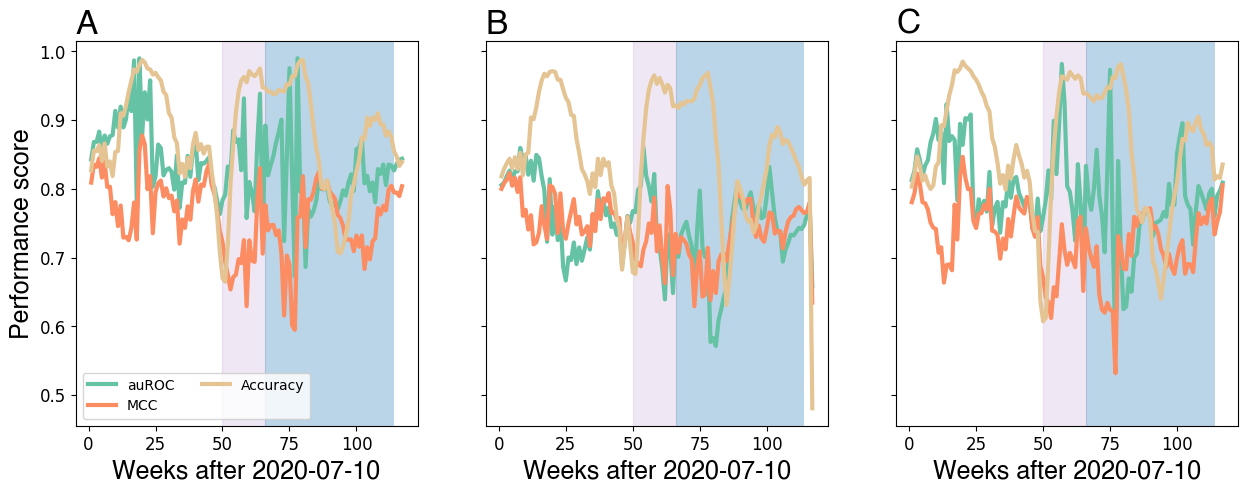

In [92]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey = 'all')

# Plot data on the same plot
axs[0].plot(weeks_to_predict, ROC_by_week_naive_period, label='auROC', linewidth = 3, color = palette[0])
axs[0].plot(weeks_to_predict, norm_MCC_by_week_naive_period, label='MCC', linewidth = 3, color = palette[1])
axs[0].plot(weeks_to_predict, accuracy_by_week_naive_period, label='Accuracy', linewidth = 3, color = palette[5])

# Plot data on the same plot
axs[1].plot(weeks_to_predict, ROC_by_week_naive_exact, label='auROC', linewidth = 3, color = palette[0])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_naive_exact, label='MCC', linewidth = 3, color = palette[1])
axs[1].plot(weeks_to_predict, accuracy_by_week_naive_exact, label='Accuracy', linewidth = 3, color = palette[5])

axs[2].plot(weeks_to_predict, ROC_by_week_naive_shifted, label='auROC', linewidth=3, color=palette[0])
axs[2].plot(weeks_to_predict, norm_MCC_by_week_naive_shifted, label='MCC', linewidth = 3, color = palette[1])
axs[2].plot(weeks_to_predict, accuracy_by_week_naive_shifted, label='Accuracy', linewidth=3, color=palette[5])

# Add labels and legend
axs[0].set_xlabel('Weeks after 2020-07-10',**hfont,  fontsize = 18 )
axs[1].set_xlabel('Weeks after 2020-07-10',**hfont,  fontsize = 18 )
axs[2].set_xlabel('Weeks after 2020-07-10',**hfont,  fontsize = 18 )

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[2].tick_params(axis='both', which='major', labelsize=12)

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')

for ax in axs:
    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    ax.add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
    ax.add_patch(polygon_omricon)

plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_naive_expanding_train_models_period_exact_shifted_test_{size_of_test_dataset}_week.png', dpi = 300)

# Full Classifier

In [63]:
new_directory = '/Users/rem76/Documents/COVID_projections/Expanding_training_set/'
os.chdir(new_directory)

In [64]:
def cross_validation_leave_geo_out(data, geography_column, geo_split, no_iterations, cv, classifier, param_grid, no_iterations_param, no_weeks_train, no_weeks_test, weeks_in_future, weight_col, keep_output, time_period):
    best_hyperparameters_per_iter = []
    auROC_per_iter = []

    for i in range(no_iterations):
        print(i)
        # Subset the HSAs from the full dataset
        geo_names = data[geography_column].unique()
        num_names_to_select = int(geo_split * len(geo_names))
        geos_for_sample = random.sample(list(geo_names), num_names_to_select)
        subset_HSAs_for_train = data[data[geography_column].isin(geos_for_sample)]
        subset_HSAs_for_test = data[~data[geography_column].isin(geos_for_sample)]

        # Create training and test data
        if time_period == 'period':
            X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_train, no_weeks=no_weeks_train, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
            X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_test, no_weeks=no_weeks_test, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
            weights_train = weights_train[0]
        elif time_period == 'exact':
            X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data(subset_HSAs_for_train, no_weeks=no_weeks_train, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
            X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data(subset_HSAs_for_test, no_weeks=no_weeks_test, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
            weights_train = weights_train[0]
        elif time_period == 'shifted':
            X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data_shifted(subset_HSAs_for_train, no_weeks=no_weeks_train, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
            X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data_shifted(subset_HSAs_for_test, no_weeks=no_weeks_test, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
            weights_train = weights_train[0]


        # Check if y_sample_test contains only 1's
        while (int(y_sample_test.sum().iloc[0])/len(y_sample_test)) == 1:
            print("All 1")
            # Subset the HSAs from the full dataset
            geo_names = data[geography_column].unique()
            num_names_to_select = int(geo_split * len(geo_names))
            geos_for_sample = random.sample(list(geo_names), num_names_to_select)
            subset_HSAs_for_train = data[data[geography_column].isin(geos_for_sample)]
            subset_HSAs_for_test = data[~data[geography_column].isin(geos_for_sample)]

            # Create training and test data
            if time_period == 'period':
                X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_train, no_weeks=no_weeks_train, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
                X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_test, no_weeks=no_weeks_test, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
                weights_train = weights_train[0]
            elif time_period == 'exact':
                X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data(subset_HSAs_for_train, no_weeks=no_weeks_train, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
                X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data(subset_HSAs_for_test, no_weeks=no_weeks_test, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
                weights_train = weights_train[0]
            elif time_period == 'shifted':
                X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data_shifted(subset_HSAs_for_train, no_weeks=no_weeks_train, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
                X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data_shifted(subset_HSAs_for_test, no_weeks=no_weeks_test, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
                weights_train = weights_train[0]

        random_search = RandomizedSearchCV(classifier, param_grid, n_iter=no_iterations_param, cv=cv, random_state=10)
        random_search.fit(X_sample_train, y_sample_train, sample_weight=weights_train)
        best_params = random_search.best_params_

        # Create the Decision Tree classifier with the best hyperparameters
        model = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')
        model_fit = model.fit(X_sample_train, y_sample_train, sample_weight=weights_train)
        y_pred = model_fit.predict_proba(X_sample_test)

        # Evaluate the accuracy of the model
        best_hyperparameters_per_iter.append(best_params)
        auROC_per_iter.append(roc_auc_score(y_sample_test, y_pred[:, 1]))

    return best_hyperparameters_per_iter[np.argmax(np.array(auROC_per_iter))]

In [65]:
clf_full_period = DecisionTreeClassifier( random_state=10, class_weight='balanced')

In [68]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = False  

no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

In [23]:
ROC_by_week_full_period = []
sensitivity_by_week_full_period = []
specificity_by_week_full_period = []
ppv_by_week_full_period = []
npv_by_week_full_period = []
accuracy_by_week_full_period = []
norm_MCC_by_week_full_period = []

for prediction_week in weeks_to_predict:
    print(prediction_week)
    no_weeks_train = range(1, int(prediction_week + train_weeks_for_initial_model) + 1)
    no_weeks_test = range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1)
    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=no_weeks_train, weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=no_weeks_test, weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full_period = weights_full_period[0].to_numpy()
    best_params = cross_validation_leave_geo_out(HSA_weekly_data_all, geography_column=geography_column, geo_split=geo_split, no_iterations=no_iterations, cv=cv, classifier=clf_full_period, param_grid=param_grid, no_iterations_param=no_iterations_param, no_weeks_train=no_weeks_train, no_weeks_test=no_weeks_test, weeks_in_future=weeks_in_future, weight_col=weight_col, keep_output=keep_output, time_period='period')
    clf_full_period = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')
    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)
  
    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)
    print(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    # Evaluate the accuracy of the model
    accuracy_by_week_full_period.append(accuracy_score(y_test_full_period, y_pred))
    ROC_by_week_full_period.append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_full_period, y_pred)

    model_name_to_save = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"

    #pickle.dump(clf_full_period, open(model_name_to_save, 'wb'))
    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    specificity_by_week_full_period.append(specificity)
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week_full_period.append(sensitvity)
    norm_MCC_by_week_full_period.append((matthews_corrcoef(y_test_full_period, y_pred) + 1)/2)

    ppv_by_week_full_period.append(ppv)
    npv_by_week_full_period.append(npv)

1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.8386347983572686


Get metrics from loaded models

In [71]:
ROC_by_week_full_period = []
sensitivity_by_week_full_period = []
specificity_by_week_full_period = []
ppv_by_week_full_period = []
npv_by_week_full_period = []
accuracy_by_week_full_period = []
norm_MCC_by_week_full_period = []

size_of_test_dataset = 1
for prediction_week in weeks_to_predict:
    model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    print(prediction_week)

    #period    

    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full = weights_full[0].to_numpy()
    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full)
    y_pred_proba = clf_full_period.predict_proba(X_test_full)

    # Evaluate the accuracy of the model
    accuracy_by_week_full_period.append(accuracy_score(y_test_full, y_pred))
    ROC_by_week_full_period.append(roc_auc_score(y_test_full, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_full, y_pred)

    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_full_period.append(sensitvity)
    specificity_by_week_full_period.append(specificity)

    ppv_by_week_full_period.append(ppv)
    npv_by_week_full_period.append(npv)

    norm_MCC_by_week_full_period.append((matthews_corrcoef(y_test_full, y_pred) + 1)/2)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


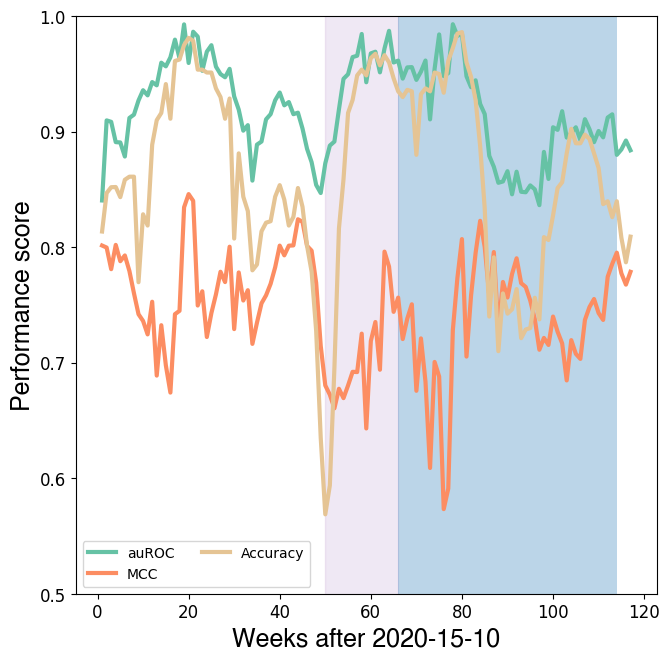

In [79]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 7.5), sharey = 'all')

# Plot data on the same plot
axs.plot(weeks_to_predict, ROC_by_week_full_period, label='auROC', linewidth = 3, color = palette[0])
axs.plot(weeks_to_predict, norm_MCC_by_week_full_period, label='MCC', linewidth = 3, color = palette[1])
axs.plot(weeks_to_predict, accuracy_by_week_full_period, label='Accuracy', linewidth = 3, color = palette[5])



# Add labels and legend
axs.set_xlabel('Weeks after 2020-07-10',**hfont,  fontsize = 18 )
axs.set_ylabel('Performance score',**hfont,  fontsize = 18)
axs.tick_params(axis='both', which='major', labelsize=12)
axs.set_ylim(0.5,1)
#add_labels_to_subplots(axs, hfont, 1.01, 24)
axs.legend(ncol = 2, loc='lower left')

polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
axs.add_patch(polygon_delta)
polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
axs.add_patch(polygon_omricon)
plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_full_expanding_train_models_period_{size_of_test_dataset}_week.png', dpi = 300)

Best and worst classifiers

In [80]:
max_index = ROC_by_week_full_period.index(max(ROC_by_week_full_period))
best_model_week = max_index - 1
print(best_model_week)
print(ROC_by_week_full_period[max_index])
# Find the index of the minimum value
min_index = ROC_by_week_full_period.index(min(ROC_by_week_full_period))
worst_model_week = min_index - 1
print(worst_model_week)
print(ROC_by_week_full_period[min_index])

76
0.993073047858942
95
0.8364337568058077


In [81]:
Best_model = "Full_model_" + time_period + "_" + str(best_model_week) + ".sav"
Worst_model = "Full_model_" + time_period + "_" + str(worst_model_week) + ".sav"

clf_full_period_best = pickle.load(open(Best_model, 'rb'))
clf_full_period_worst = pickle.load(open(Worst_model, 'rb'))

Best_model = "Full_model_best" + time_period + ".sav"
Worst_model = "Full_model_worst" + time_period + ".sav"
pickle.dump(clf_full_period_best, open(Best_model, 'wb'))
pickle.dump(clf_full_period_worst, open(Worst_model, 'wb'))

In [82]:
Best_model

'Full_model_bestperiod.sav'